In [67]:
# Import postgresql libraries
import psycopg2
from psycopg2 import Error
from psycopg2.extensions import AsIs

# imports
from MCForecastTools import MCSimulation
from time import sleep
import math
import requests
import json
import panel as pn
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from dotenv import load_dotenv
from pandas import json_normalize
    
import warnings
warnings.filterwarnings('ignore')

In [68]:
# Set up Panel Plotly extension
pn.extension('plotly')

In [69]:
# Import hvplot.pandas after pn.extension
# This avoids plotly initialization failure
import hvplot.pandas

In [70]:
# Define path to datasets
dow_jones_list_path = Path('../data/rawdata/dow_jones_list.json')
sp_500_list_path = Path('../data/rawdata/sp_500_list.json')
nasdaq_100_list_path = Path('../data/rawdata/nasdaq_100_list.json')

In [71]:
# Base URL for fmp
fmp_base_url = 'https://financialmodelingprep.com/api/v3/'

In [72]:
# Read in API keys
load_dotenv('./billy/api_keys.env')
map_box_api = os.getenv("MAPBOX_TOKEN")
fmp_api = os.getenv("FMP_API_KEY")
postgres_user = os.getenv("POSTGRES_USER")
postgres_pwd = os.getenv("POSTGRES_PWD")

px.set_mapbox_access_token(map_box_api)

In [73]:
# Read in datasets
dow_jones_list = pd.read_json (dow_jones_list_path)
sp_500_list = pd.read_json (sp_500_list_path)
nasdaq_100_list = pd.read_json (nasdaq_100_list_path)

# Add MarketCap Column
dow_jones_list['marketcap'] = 0
sp_500_list['marketcap'] = 0
nasdaq_100_list['marketcap'] = 0

## Bitcoin Forecasting

In [74]:
# Define Parameters
exchange = 'Binance'
symbol = 'BTCUSDT'
indicator_type = 'orderbook'
name = '0-1%'
interval = '3600'

# Create parameterized url
base_url = "https://api.topfol.io/indicators/candle?"
parameters_url = "startDate=2021-02-20&endDate=2021-04-20&exchange="+exchange+"&symbol="+symbol+"&indicator_type="+indicator_type+"&name="+name+"&interval="+interval
request_url = base_url + parameters_url

# Submit request and format output
response_data = requests.get(request_url)
pages = int(response_data.headers['page-amount'])

print (f'Number of Pages is {pages}')

new_results = True
page = 1
df_btcusdt_data = pd.DataFrame()

topfolio_api = requests.get(request_url).json()

data = topfolio_api

for page in range(2, pages+1):
    topfolio_api = requests.get(request_url + f"&page={page}").json()
    data.extend(topfolio_api)
    page += 1
    
df_btcusdt_data = json_normalize(data)


Number of Pages is 15


## Variable Definitions

In [75]:
# Column Management
profile_column_names = ['symbol','price','beta','volAvg','mktCap','lastDiv','range','changes','companyName','currency','cik','isin','cusip',
                'exchange','exchangeShortName','industry','website','description','ceo','sector','country','fullTimeEmployees',
                'phone','address','city','state','zip','dcfDiff','dcf','image','ipoDate','defaultImage','isEtf','isActivelyTrading']

quote_column_names = ['symbol','name','price','changesPercentage','change','dayLow','dayHigh','yearHigh','yearLow','marketCap','priceAvg50',
                      'priceAvg200','volume','avgVolume','exchange','open','previousClose','eps','pe','earningsAnnouncement',
                      'sharesOutstanding','timestamp']

rating_column_names = ['symbol','ratingdate','rating','ratingScore','ratingRecommendation','ratingDetailsDCFScore','ratingDetailsDCFRecommendation',
                       'ratingDetailsROEScore','ratingDetailsROERecommendation','ratingDetailsROAScore','ratingDetailsROARecommendation',
                       'ratingDetailsDEScore','ratingDetailsDERecommendation','ratingDetailsPEScore','ratingDetailsPERecommendation',
                       'ratingDetailsPBScore','ratingDetailsPBRecommendation']

column_names = ['symbol','beta','volAvg','mktCap','lastDiv','range','changes','companyName','currency','cik','isin','cusip',
                'exchange','exchangeShortName','industry','website','description','ceo','sector','country','fullTimeEmployees',
                'phone','address','city','state','zip','dcfDiff','dcf','image','ipoDate','defaultImage','isEtf','isActivelyTrading',
                'price','changesPercentage','change','dayLow','dayHigh','yearHigh','yearLow','marketCap','priceAvg50','priceAvg200',
                'volume','avgVolume','exchange','open','previousClose','eps','pe','earningsAnnouncement','sharesOutstanding','timestamp',
                'held','totalheld','ratingdate','rating','ratingScore','ratingRecommendation','ratingDetailsDCFScore',
                'ratingDetailsDCFRecommendation','ratingDetailsROEScore','ratingDetailsROERecommendation','ratingDetailsROAScore',
                'ratingDetailsROARecommendation','ratingDetailsDEScore','ratingDetailsDERecommendation','ratingDetailsPEScore',
                'ratingDetailsPERecommendation','ratingDetailsPBScore','ratingDetailsPBRecommendation']

rating_names= ['symbol','companyName','exchangeShortName','industry','sector','dayLow','dayHigh','yearHigh','yearLow','priceAvg50','priceAvg200',
               'eps','pe','sharesOutstanding','held','totalheld','ratingdate','rating','ratingScore','ratingDetailsDCFScore','ratingDetailsROEScore',
               'ratingDetailsROAScore','ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']

In [76]:
# Portfolio Holdings
jorge_holdings = {'AMZN':1,'BA':14,'BABA':10,'DAC':20,'FLGT':141,'PYPL':16}

william_holdings = {'T': 70,'LI': 20,'LNC': 10,'ONTO': 10,'UWMC': 100,'ABBV': 10,'ALL': 10,'GOLD': 100,'BEAM': 10,'BNGO': 70,
                    'CTXS': 10,'NIO': 40,'NVS': 11,'PCAR': 10,'PLTR': 36,'PYPL': 4,'PENN': 8,'PWOD': 45,'RPTX': 10,'RKT': 25,
                    'TER': 8,'VZ': 40}

# Removed from list 'CCIV': 145,'GNOG': 220, 'RBLX': 10,'SGFY': 50,

juancarlos_holdings = {'ZM':150,'MSFT':150,'SQ':150,'BABA':150,'AAPL':150,'TSLA':150,'COST':150,'T':150,'FB':150,'DIS':150,'UBER':150,'JPM':150,'TSN':150,'QCOM':150,'ALLY':150}

In [77]:
# Name to convert big numbers to human readable
millnames = ['',' Thousand',' Million',' Billion',' Trillion']

## Database Functions

In [78]:
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn
 
def postgresql_to_dataframe(conn, select_query, columns):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    
    return df

In [79]:
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

In [80]:
def append_market_cap(dataset):
    df_marketcap = pd.DataFrame()
    count = 0
    for symbol in dataset['symbol']:
        # Query company info from api
        fmp_profile = (f'market-capitalization/{symbol}?apikey={fmp_api}')
        fmp_profile_response = requests.get(fmp_base_url + fmp_profile)
        data = fmp_profile_response.json()
        marketcap = data[0]['marketCap']
        dataset['marketcap'][count] = marketcap
        count += 1
        sleep(0.05)
        
    return dataset


def market_movers():
    mover_column_names = ['date','TotalScore','ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                          'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']
    score_column_names = ['ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                          'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']
    fmp_gainers = (f'gainers?apikey={fmp_api}')
    fmp_losers = (f'losers?apikey={fmp_api}')
    # request data from api provider
    fmp_gainers_response = requests.get(fmp_base_url + fmp_gainers)
    fmp_losers_response = requests.get(fmp_base_url + fmp_losers)
    # Store response
    gainers_data = fmp_gainers_response.json()
    losers_data = fmp_losers_response.json()
    # Create dataframes
    output = pd.DataFrame()
    df_gainers = pd.DataFrame(gainers_data)
    df_losers = pd.DataFrame(losers_data)
    df_movers = pd.concat([df_gainers,df_losers],ignore_index=True)
    df_movers = pd.concat([df_movers,pd.DataFrame(columns = mover_column_names)])
    count = 0
    # Iterate through gainer positions
    for ticker in list(df_movers['ticker']):
        sum = 0
        # build url
        fmp_rating = (f'rating/{ticker}?apikey={fmp_api}')
        # request data from api provider
        fmp_rating_response = requests.get(fmp_base_url + fmp_rating)
        # Store response
        if str(fmp_rating_response.json())[1:-1] == '':
            count += 1
            continue
        else:
            rating_data = fmp_rating_response.json()[0]
            df_movers['price'] = df_movers['price'].astype(float)
            df_movers['changes'] = df_movers['changes'].astype(float)
            df_movers['changesPercentage'][count] = df_movers['changes'][count] / (df_movers['price'][count] - df_movers['changes'][count])
            for col in mover_column_names:
                if col == 'TotalScore':
                    for col2 in score_column_names:
                        sum += rating_data.get(col2)
                    df_movers[col][count] = sum
                else:
                    df_movers[col][count] = rating_data.get(col)
            count += 1
            
    # Clean up dataframe
    df_movers.dropna(inplace=True)
    df_movers.reset_index(inplace=True)
    df_movers.drop(['index'], axis=1, inplace=True)
    df_movers.rename(columns = {'companyName':'Name','rating':'Rating','ratingScore':'Score','ratingDetailsDCFScore':'DCF',
                                'ratingDetailsROEScore':'ROE','ratingDetailsROAScore':'ROA','ratingDetailsDEScore':'DE',
                                'ratingDetailsPEScore':'PE','ratingDetailsPBScore':'PB','changesPercentage':'Percentage'}, inplace=True)
    
    long_ideas = df_movers[['ticker','Name','price','changes','Percentage']][(df_movers['TotalScore']>23) & (df_movers['Percentage']<0)]
    short_ideas = df_movers[['ticker','Name','price','changes','Percentage']][(df_movers['TotalScore']<17) & (df_movers['Percentage']>0)]
    
    return long_ideas, short_ideas

def portfolio_gather_data(dataset):
    final_df = pd.DataFrame(columns = column_names)
    to_append = []

    # Iterate through positions
    for ticker in list(dataset.keys()): 
        # build url
        fmp_profile = (f'profile/{ticker}?apikey={fmp_api}')
        fmp_quote = (f'quote/{ticker}?apikey={fmp_api}')
        fmp_rating = (f'rating/{ticker}?apikey={fmp_api}')
        # request data from api provider
        fmp_profile_response = requests.get(fmp_base_url + fmp_profile)
        fmp_quote_response = requests.get(fmp_base_url + fmp_quote)
        fmp_rating_response = requests.get(fmp_base_url + fmp_rating)
        # Store response
        profile_data = fmp_profile_response.json()[0]
        quote_data = fmp_quote_response.json()[0]
        rating_data = fmp_rating_response.json()[0]
        
        # prepare profile dataframe
        profile_columns = profile_data.keys()
        to_append_profile = [profile_data[column] for column in profile_columns]
        to_append_profile.pop(1)
        
        # prepare quote dataframe
        quote_columns = quote_data.keys()
        to_append_quote = [quote_data[column] for column in quote_columns]
        to_append_quote.pop(0)
        to_append_quote.pop(0)
        
        # preapare rating dataframe
        rating_columns = rating_data.keys()
        to_append_rating = [rating_data[column] for column in rating_columns]
        to_append_rating.pop(0)
        
        # Create list
        to_append_calculations = [dataset.get(ticker), dataset.get(ticker)*to_append_quote[0]]
        
        # Concat all fields
        to_append = to_append_profile + to_append_quote + to_append_calculations + to_append_rating
        
        df_length = len(final_df)
        final_df.loc[df_length] = to_append          
        
    return final_df

## Visualization Functions

In [101]:
def index_sector_plot(dataset, title):
    pie_plot = px.pie(
        dataset,
        values='marketcap',
        names='sector',
        title=title,
        width=500,
        hover_data={
        #"marketcap": millify(dataset['marketcap']),
        }
    )
    
    return pie_plot

def portfolio_sector_plot(dataset, title):
    pie_plot = px.pie(
        dataset,
        values='totalheld',
        names='sector',
        title=title,
        width=500,
        hover_data={
        #"marketcap": millify(dataset['marketcap']),
        }
    )
    
    return pie_plot

def portfolio_ratings_plot(dataset):
    rating_view = ['companyName','rating','ratingScore','ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                   'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']
    
    df_rating = dataset[rating_view]
    
    df_rating.rename(columns = {'companyName':'Name','rating':'Rating','ratingScore':'Score','ratingDetailsDCFScore':'DCF',
                                'ratingDetailsROEScore':'ROE','ratingDetailsROAScore':'ROA','ratingDetailsDEScore':'DE',
                                'ratingDetailsPEScore':'PE','ratingDetailsPBScore':'PB'}, inplace=True)
    
    # Add our Total Score value and drop original data Score
    sum_column = df_rating['DCF']+df_rating['ROE']+df_rating['ROA']+df_rating['DE']+df_rating['PE']+df_rating['PB']
    df_rating['Total Score'] = sum_column
    df_rating.drop(['Score'], axis=1)
    
    # Rearrange columns as per Juan Carlos
    df_rating = df_rating[['Name','Rating','Total Score','DCF','ROE','ROA','DE','PE','PB']]
    
    return df_rating

# JCs Distribution plot
def portfolio_distribution_plot(dataset):
    pie_plot = dataset.set_index('symbol').plot.pie(y='totalheld',
                                                    figsize=(12,12),
                                                    startangle=0,
                                                    autopct='%1.1f%%',
                                                    legend=False).figure
    return pie_plot

## Other

In [82]:
df_jorge_holdings = portfolio_gather_data(jorge_holdings)
df_william_holdings = portfolio_gather_data(william_holdings)
df_juancarlos_holdings = portfolio_gather_data(juancarlos_holdings)

In [83]:
dow_jones_list = append_market_cap(dow_jones_list)
#dow_jones_list.to_csv('../data/cleandata/dow_jones_list.csv', index=False)

In [84]:
nasdaq_100_list = append_market_cap(nasdaq_100_list)
#nasdaq_100_list.to_csv('../data/cleandata/nasdaq_100_list.csv', index=False)

In [85]:
sp_500_list = append_market_cap(sp_500_list)
#sp_500_list.to_csv('../data/cleandata/sp_500_list.csv', index=False)

In [86]:
# Connection parameters, yours will be different
#param_dic = {
#    "host"      : "localhost",
#    "database"  : "project1_db",
#    "user"      : postgres_user,
#    "password"  : postgres_pwd
#}

In [87]:
# create a connection to the database
#conn = connect(param_dic)

## Dashboard

In [88]:
dow_jones_marketcap = millify(dow_jones_list['marketcap'].sum())
nasdaq_100_marketcap = millify(nasdaq_100_list['marketcap'].sum())
sp_500_marketcap = millify(sp_500_list['marketcap'].sum())
jorge_total = millify(df_jorge_holdings['totalheld'].sum())
william_total = millify(df_william_holdings['totalheld'].sum())
juancarlos_total = millify(df_juancarlos_holdings['totalheld'].sum())

In [54]:
# Find the ideas for screener tab
long_ideas, short_ideas = market_movers()

TypeError: pie() got an unexpected keyword argument 'top'

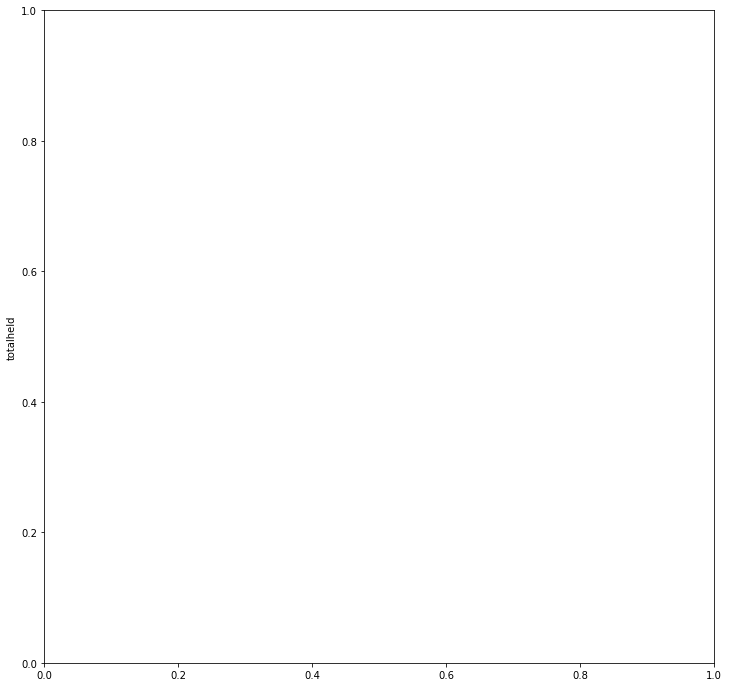

In [100]:
welcome_title = "### This dashboard was developed to analyze existing portfolios and to provide." \
                " and gross rent in San Francisco, California from 2010 to 2016.  You can navigate through the tabs above to explore" \
                " more details about the evolution of the real estate market in The Golden City across these years."

welcome_tab = pn.pane.Markdown(welcome_title)

sector_tab = pn.Column(pn.Row(index_sector_plot(dow_jones_list, f'Dow Jones ({dow_jones_list.count()[0]} stocks / {dow_jones_marketcap})'),
                                    index_sector_plot(nasdaq_100_list, f'Nasdaq ({nasdaq_100_list.count()[0]} stocks / {nasdaq_100_marketcap})'),
                                    index_sector_plot(sp_500_list, f'S&P 500 ({sp_500_list.count()[0]} stocks / {sp_500_marketcap})')),                            
                             pn.Row(portfolio_sector_plot(df_jorge_holdings, f"Jorge's Portfolio ({len(jorge_holdings)} stocks / {jorge_total})"),
                                    portfolio_sector_plot(df_william_holdings, f"William's Portfolio ({len(william_holdings)} stocks / {william_total})"),
                                    portfolio_sector_plot(df_juancarlos_holdings, f"JC's Portfolio ({len(juancarlos_holdings)} stocks / {juancarlos_total})")))

rating_tab = pn.Column(pn.pane.Markdown("""
                                        ### Ratings
                                        |           |                        |           |                        |
                                        | ---:      | :---                   | ---:      | :---                   |
                                        | **DCF**   | - Discount Cash Flow   | **DE**    | - Debt-Equity          |
                                        | **ROE**   | - Return on Equity     | **PE**    | - Price-Earnings Ratio |
                                        | **ROA**   | - Return on Assets     | **PB**    | - Price-Book Ration    | 
                                        
                                        """),
                       pn.Tabs(('Jorge', pn.widgets.DataFrame(portfolio_ratings_plot(df_jorge_holdings),
                                                              show_index=False,
                                                              autosize_mode='fit_columns',
                                                              width=900)),
                               ('William', pn.widgets.DataFrame(portfolio_ratings_plot(df_william_holdings),
                                                                show_index=False,
                                                                autosize_mode='fit_columns',
                                                                width=900)),
                               ('JC', pn.widgets.DataFrame(portfolio_ratings_plot(df_juancarlos_holdings),
                                                                    show_index=False,
                                                                    autosize_mode='fit_columns',
                                                                    width=900))),
                       )

rebalance_text = "### Your Portfolio Investment Distribution at a glance" 

rebalance_tab = pn.Column(pn.Tabs(('Jorge', pn.Column(pn.pane.Markdown(rebalance_text),
                                                       portfolio_distribution_plot(df_jorge_holdings))),
                                   ('William', pn.Column(pn.pane.Markdown(rebalance_text), 
                                                         portfolio_distribution_plot(df_william_holdings))),
                                   ('JC', pn.Column(pn.pane.Markdown(rebalance_text), 
                                                    portfolio_distribution_plot(df_juancarlos_holdings)))))

screener_tab = pn.Column(pn.pane.Markdown("## Long Ideas"),
                         pn.widgets.DataFrame(long_ideas,show_index=False,autosize_mode='fit_columns'),
                         pn.pane.Markdown("## Short Ideas"),
                         pn.widgets.DataFrame(short_ideas,show_index=False,autosize_mode='fit_columns'))

portfolio_forecast_tab = pn.pane.Markdown(welcome_title)

btc_forecast_tab = pn.pane.Markdown(welcome_title)


Column
    [0] Markdown(str, width=700)
    [1] Tabs
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Plotly(Figure)
                [1] Plotly(Figure)
                [2] Plotly(Figure)
            [1] Row
                [0] Plotly(Figure)
                [1] Plotly(Figure)
                [2] Plotly(Figure)
        [2] Column
            [0] Tabs
                [0] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
                [1] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
                [2] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
        [3] Column
            [0] Markdown(str)
            [1] Tabs
                [0] DataFrame(autosize_mode='fit_columns', show_index=False, value=              ..., width=900)
                [1] DataFrame(autosize_mode='fit_columns', show_index=False, value=                          ..., width=900)
                [2] DataFrame(autosize_mode='fit_columns', show_index=False, value=              ..., width=900)
        [4] Column
            [0] Markdown(str)
            [1] DataFrame(autosize_mode='fit_columns', show_index=False, value=   ticker     ...)
            [2] Markdown(str)
            [3] DataFrame(autosize_mode='fit_columns', show_index=False, value=  ticker      ...)
        [5] Markdown(str)
        [6] Markdown(str)
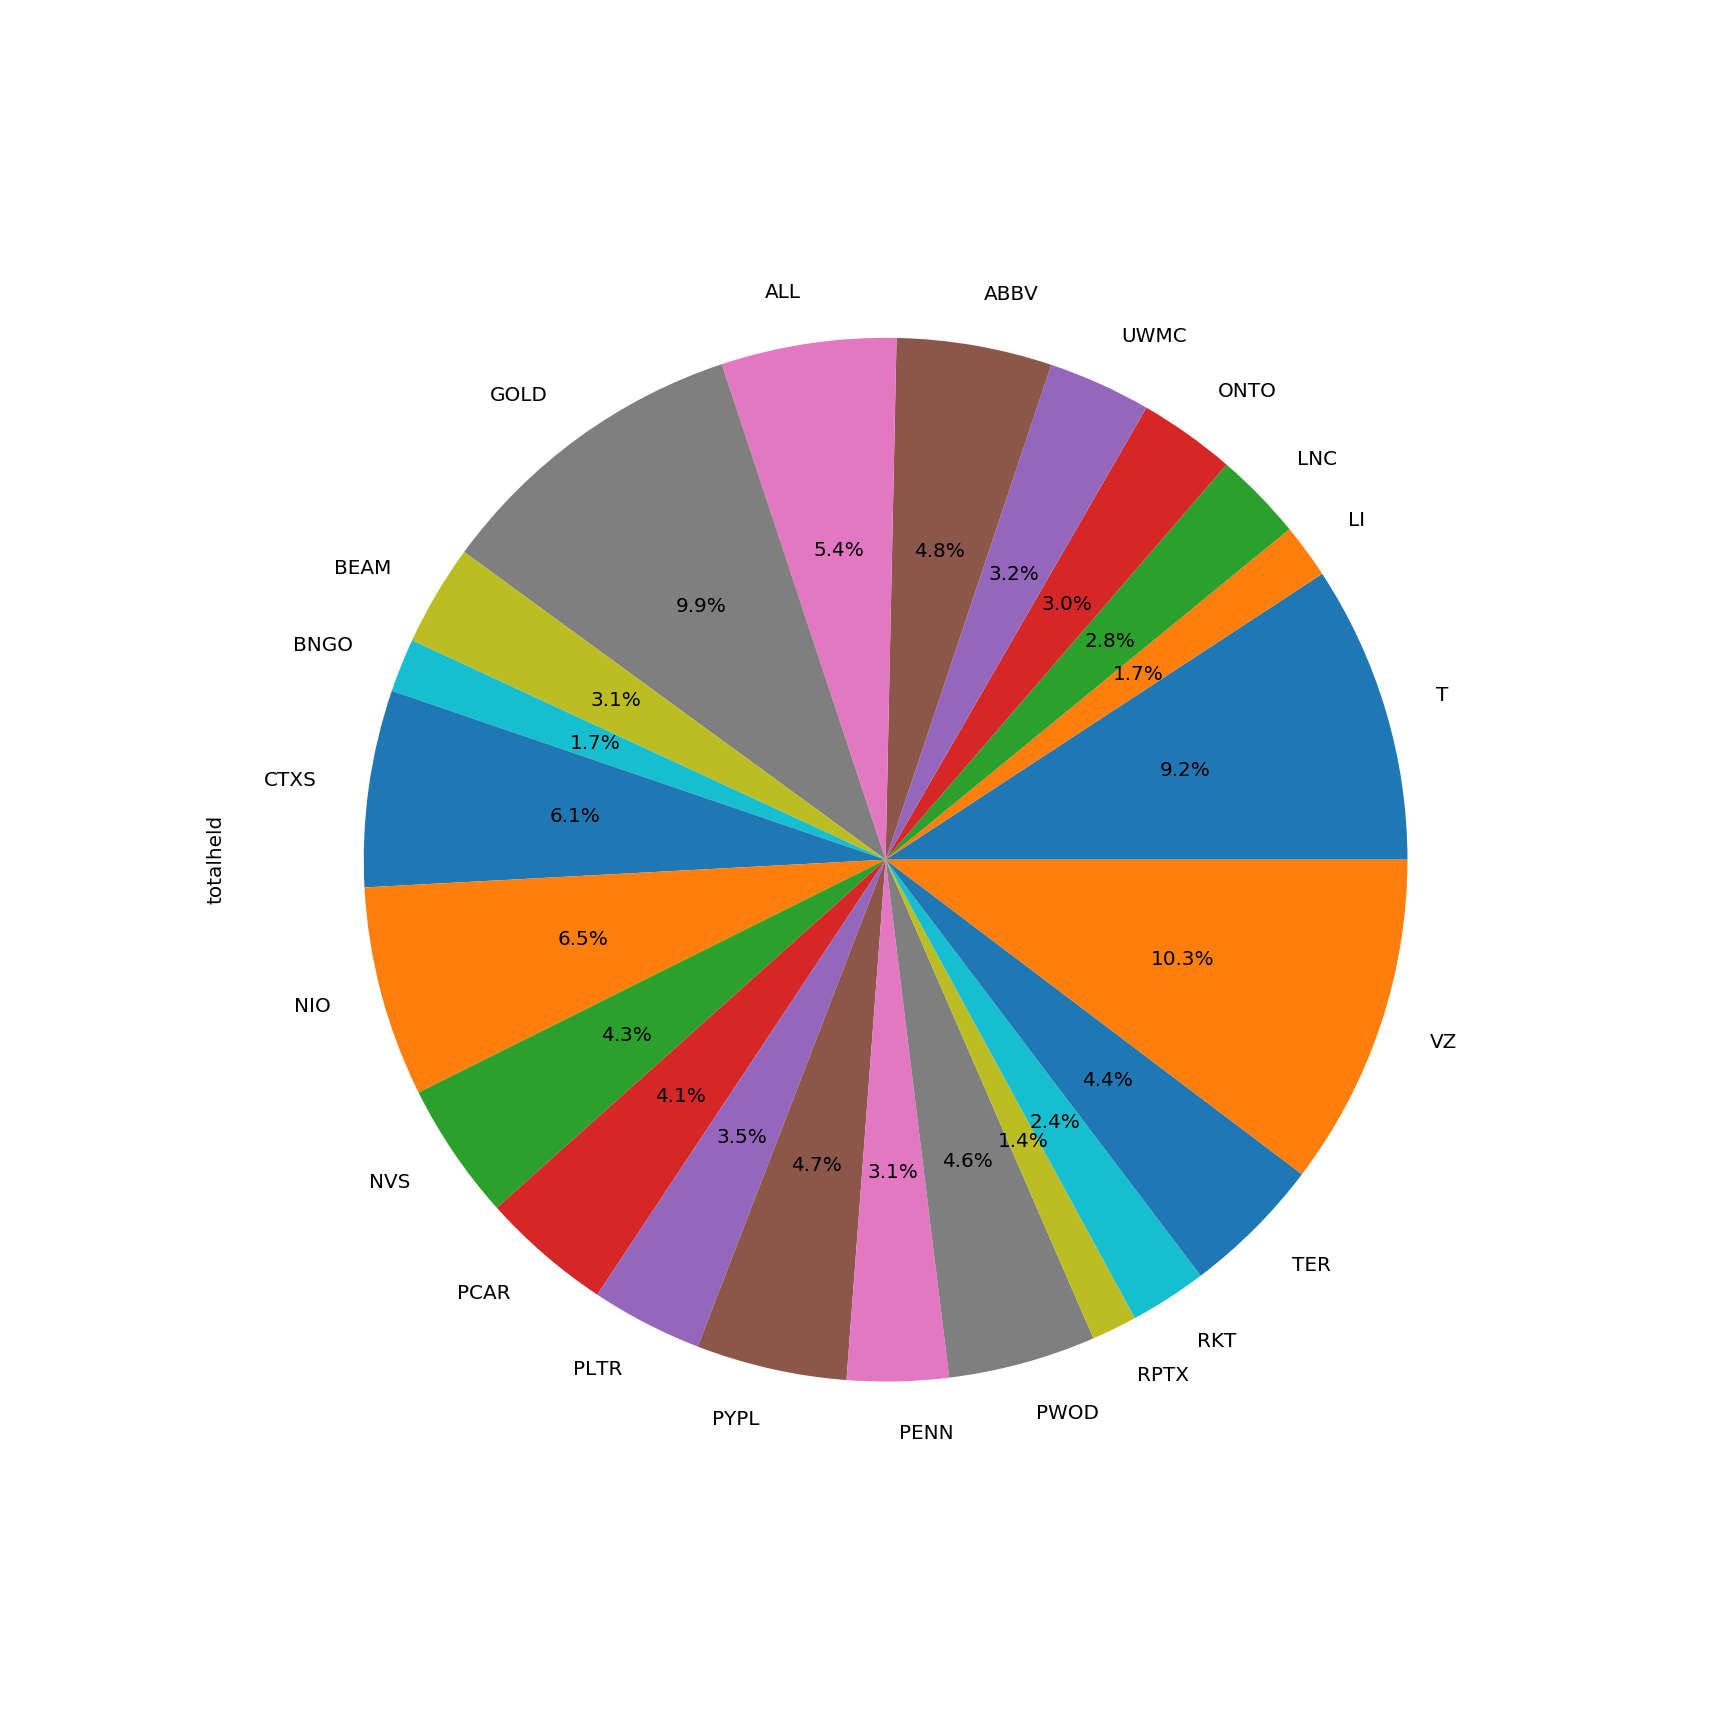
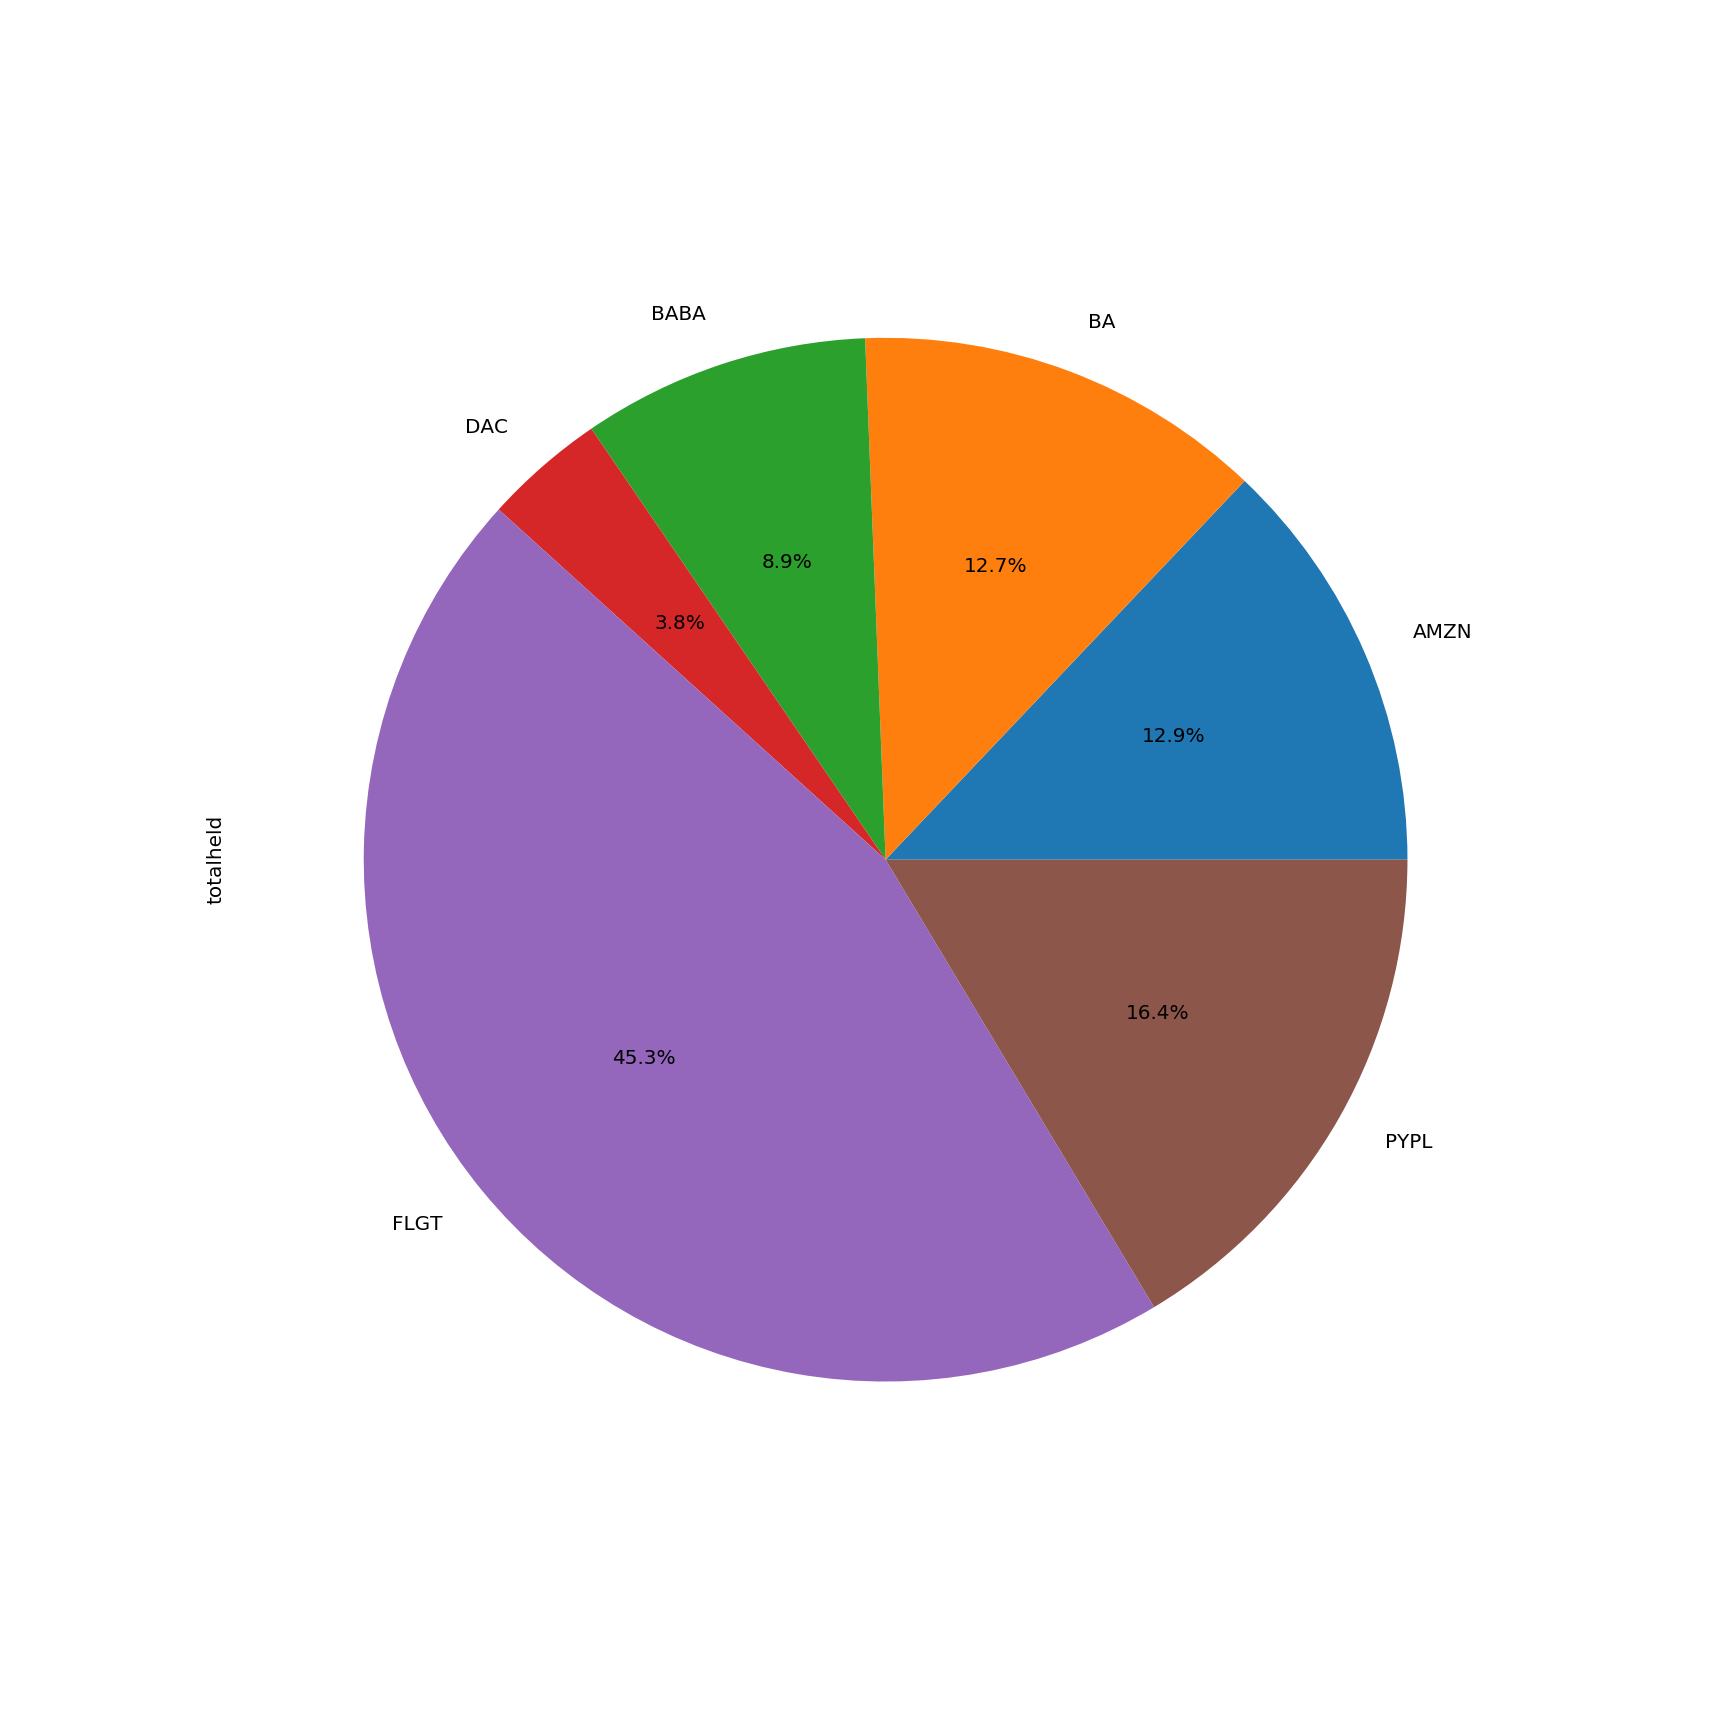
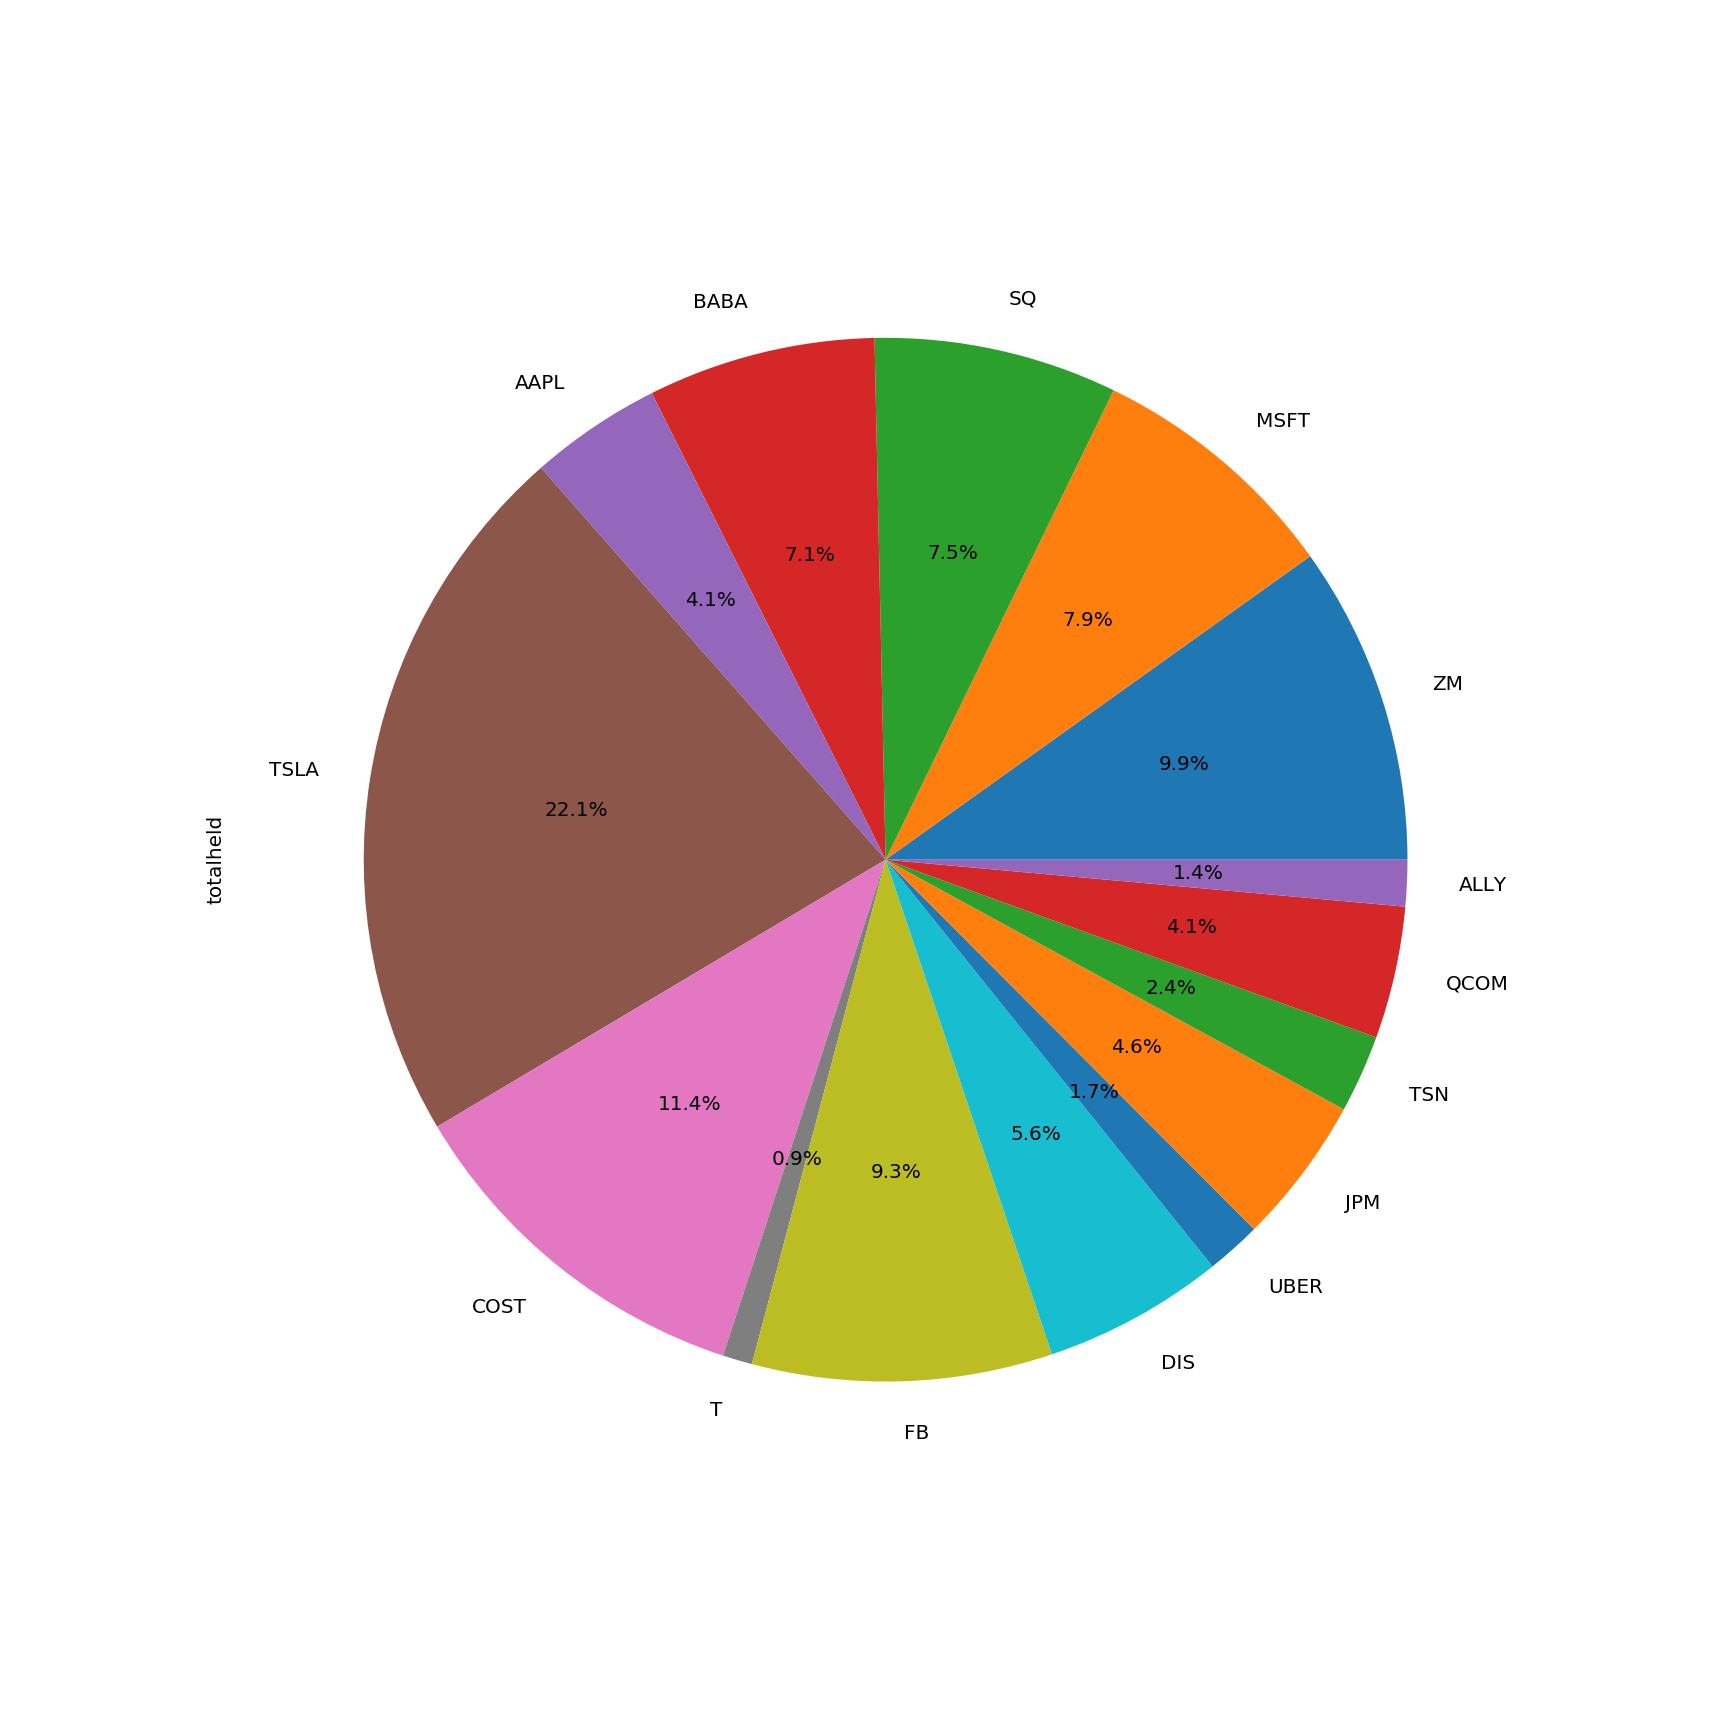

In [98]:
# Create a Title for the Dashboard
dashboard_title = '# Portfolio Analyzer'

# Create a tab layout for the dashboard
index_analysis_dashboard = pn.Column(pn.pane.Markdown(dashboard_title, width=700),pn.Tabs(('Welcome', welcome_tab),
                                                                                          ('Sector', sector_tab),
                                                                                          ('Rebalance', rebalance_tab),
                                                                                          ('Ratings', rating_tab),
                                                                                          ('Screener', screener_tab),
                                                                                          ('Portfolio Forecast', portfolio_forecast_tab),
                                                                                          ('Bitcoin Forecast', btc_forecast_tab)))                                    
                                       
# Create the dashboard
index_analysis_dashboard.servable()